## Fine-tune Stable Diffusion with DreamBooth and LoRA.

#### Step 1: Install libraries and dependencies.

In [ ]:
!pip install bitsandbytes transformers accelerate peft -q

Get the diffusers repository from HuggingFace.

In [ ]:
!pip install git+https://github.com/huggingface/diffusers.git -q

Download diffusers SDXL DreamBooth training script.

In [ ]:
!wget https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth_lora_sdxl.py

#### Step 2: Training data

Create a folder named `SDXL_train` and upload all your training images in it. Make sure all the images are either `.png` or `.jpg`

In [ ]:
import os
from google.colab import files


local_dir = "./SDXL_train/"
os.makedirs(local_dir)
os.chdir(local_dir)

# Browse the images from your computer and upload it into the SDXL_train directory.
uploaded_images = files.upload()
os.chdir("/content")

Preview the images.

In [5]:
from PIL import Image

def image_grid(imgs, rows, cols, resize=256):

    if resize is not None:
        imgs = [img.resize((resize, resize)) for img in imgs]
    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

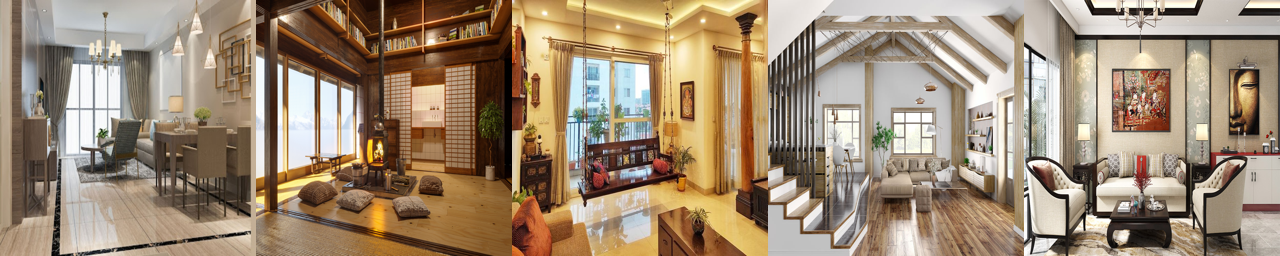

In [6]:
import glob

# change path to display images from your local dir
img_paths = "./SDXL_train/*.jpg"
imgs = [Image.open(path) for path in glob.glob(img_paths)]

num_imgs_to_preview = 5
image_grid(imgs[:num_imgs_to_preview], 1, num_imgs_to_preview)

**Generate custom captions with BLIP**

Load BLIP to auto caption your images.

In [ ]:
import requests
from transformers import AutoProcessor, BlipForConditionalGeneration
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

# load the processor and the captioning model
blip_processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base",torch_dtype=torch.float16).to(device)

# captioning utility
def caption_images(input_image):
    inputs = blip_processor(images=input_image, return_tensors="pt").to(device, torch.float16)
    pixel_values = inputs.pixel_values

    generated_ids = blip_model.generate(pixel_values=pixel_values, max_length=50)
    generated_caption = blip_processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return generated_caption

In [8]:
import glob
from PIL import Image

# create a list of (Pil.Image, path) pairs
local_dir = "./SDXL_train/"
imgs_and_paths = [(path,Image.open(path)) for path in glob.glob(f"{local_dir}*.jpg")]

#### Add a token identifier

Let's incorporate a token identifier (e.g., TOK) into each caption by introducing a caption prefix.

Feel free to customize the prefix based on the specific concept you are training on.

For example: If you're fine-tuning on -
*   Human face - "Photo of a TOK person"
*   Car - "A photo of a TOK car"
*   Styles - "In the style of watercolour"



In [9]:
import json

caption_prefix = "a photo of TOK home, "
with open(f'{local_dir}metadata.jsonl', 'w') as outfile:
  for img in imgs_and_paths:
      caption = caption_prefix + caption_images(img[1]).split("\n")[0]
      entry = {"file_name":img[0].split("/")[-1], "prompt": caption}
      json.dump(entry, outfile)
      outfile.write('\n')

Free up some memory.

In [10]:
import gc

# Delete the BLIP pipelines and free up some memory.
del blip_processor, blip_model
gc.collect()
torch.cuda.empty_cache()

#### Step 3: Start training

Initialize `accelerate`:

In [11]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!accelerate config default

accelerate configuration saved at /root/.cache/huggingface/accelerate/default_config.yaml


#### Setting the hyperparameters
To ensure seamless integration of DreamBooth with LoRA on a resource-intensive pipeline like Stable Diffusion XL, we are implementing the following techniques:

* Gradient checkpointing (`--gradient_accumulation_steps`)
* 8-bit Adam (`--use_8bit_adam`)
* Mixed-precision training (`--mixed-precision="fp16"`)

For custom captions, the installation of the `datasets` library is required. However, if you intend to train exclusively with `--instance_prompt`, you have the option to skip this step. In such instances, please specify `--instance_data_dir` instead of `--dataset_name`.

In [12]:
!pip install datasets -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.1 MB/s eta 0:00:00


 - Specify your LoRA model repository name using `--output_dir`.
 - Use `--caption_column` to indicate the name of the caption column in your dataset.

 In this example, "prompt" was used to save captions in the metadata file; feel free to modify this based on your requirements.

In [ ]:
#!/usr/bin/env bash
!accelerate launch train_dreambooth_lora_sdxl.py \
  --pretrained_model_name_or_path="stabilityai/stable-diffusion-xl-base-1.0" \
  --pretrained_vae_model_name_or_path="madebyollin/sdxl-vae-fp16-fix" \
  --dataset_name="SDXL_train" \
  --output_dir="SDXL_LoRA_model" \
  --caption_column="prompt"\
  --mixed_precision="fp16" \
  --instance_prompt="a photo of TOK home" \
  --resolution=1024 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=3 \
  --gradient_checkpointing \
  --learning_rate=1e-4 \
  --snr_gamma=5.0 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --mixed_precision="fp16" \
  --use_8bit_adam \
  --max_train_steps=500 \
  --checkpointing_steps=717 \
  --seed="0"

2024-01-15 11:34:03.959918: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-15 11:34:03.959977: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-15 11:34:03.961264: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-15 11:34:05.847055: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
01/15/2024 11:34:07 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

You are using a model of type clip_text_model to instantiate a model of ty

#### Step 4: Inference model

In [ ]:
import torch
from diffusers import DiffusionPipeline, AutoencoderKL

vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    vae=vae,
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True
)
pipe.load_lora_weights('/content/SDXL_LoRA_model/pytorch_lora_weights.safetensors')
_ = pipe.to("cuda")

In [ ]:
prompt = "a photo of TOK home, Italian marble, red carpet"

image = pipe(prompt=prompt, num_inference_steps=25).images[0]
image